In [ ]:
!pip install ttax==0.0.2
!pip install ttpy

In [2]:
import jax
import tt
import jax.numpy as jnp
from numpy import random
import numpy as np
import matplotlib.pyplot as plt
import ttax
%matplotlib inline

In [3]:
seed = 42
jaxkey = jax.random.PRNGKey(seed)

In [4]:
def orthoproject(x, v):
  """
  returns orthoprojection of x onto span{v}
  """
  return v - jnp.inner(x, v) * x

def retract(v, x):
  """
  returns retraction R_x(v) = (x + v) / |x + v|
  """
  vx = v + x
  return vx / jnp.linalg.norm(vx, ord=2)

def armijo_backtracking(f, dfx, x, alpha=1, beta=1e-4, tau=0.5):
  """
  line-search algorithm. The notation is taken from 
    https://www.numerical.rl.ac.uk/people/nimg/oumsc/lectures/uepart2.2.pdf
  """

  """
    not working (:
  """

  while f(x - alpha*dfx) - f(x) <= alpha*beta*jnp.linalg.norm(dfx)**2 :
    alpha = alpha * tau
  return alpha

def armijo_backtracking_2(init, grad, mul, beta, func, x):
    """
    using this one
    """
    alpha = init
    i = 0
    iters = 100
    while func(x) < func(retract(x, -alpha * grad)) + mul*alpha*jnp.linalg.norm(grad)**2 and i < iters:
        alpha *= beta
        i += 1
    return alpha

In [5]:
def make_objective(A, b):
  """
  returns a callable functional of x
    0.5 * x*A*x - x*b 
  """
  return lambda x: jnp.squeeze((0.5 * jnp.inner(x, A @ x) - jnp.inner(x, b)))

def make_residual(A, b):
  """
   returns a callable functional of x
    |A*x - b| 
  """
  return lambda x: jnp.linalg.norm(A @ x - b, ord=2)

In [52]:
def solve(A, b, iters=500, tol=1e-2, debug=False):
  """
  solves system Ax = b with a GD method using Riemann optimization technique
  and returns n*1 vector
  :params:
    A       : n*n matrix
    b       : n*1 vector
    iters   : max number of descent iterations
    tol     : desired accuracy
  """
  n = A.shape[0]

  residual = make_residual(A, b)
  objective = make_objective(A, b)

  i = 0
  x = jax.random.uniform(jaxkey, (n,))

  residuals = []
  relresiduals = []
  energies = []

  while residual(x) > tol and i < iters:
    grad_at = jax.grad(objective)
    riemann_grad = orthoproject(x, grad_at(x))
    alpha = armijo_backtracking_2(1, riemann_grad, 1e-5, 0.8, objective, x)
    # alpha = armijo_backtracking(objective, riemann_grad, x)
    x = retract(x, -alpha*riemann_grad)

    residuals.append( residual(x) ) 
    relresiduals.append( residual(x) / jnp.linalg.norm(A @ x, ord=2) )
    energies.append( objective(x) )

    if i % 10 == 0 and debug:
      print(f"{i} th iteration: {residuals[-1]}")

    i += 1

  return x, residuals

попробуем на простом примере

In [7]:
A = jnp.array([
               [100, 2, 3, 4],
               [2, 10, 1, 3],
               [3, 1, 7, 2],
               [4, 3, 2, 30]
], dtype=jnp.float64)
b = jnp.array([1, 2, 3, 4], dtype=jnp.float64)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3026: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


In [8]:
x, residuals = solve(A, b, iters=100, tol=1, debug=True)

0 th iteration: 55.86521530151367
10 th iteration: 19.825815200805664
20 th iteration: 18.64072608947754
30 th iteration: 5.232542514801025
40 th iteration: 4.291931629180908
50 th iteration: 4.191511154174805
60 th iteration: 4.167981147766113
70 th iteration: 4.1635541915893555
80 th iteration: 4.162425518035889
90 th iteration: 4.16219425201416


ValueError: ignored

беда с длиной шага (вероятно, нужно менять armijo backtracking)

In [9]:
x

DeviceArray([-0.02623977,  0.14906824,  0.9863243 ,  0.0652263 ], dtype=float32)

хм

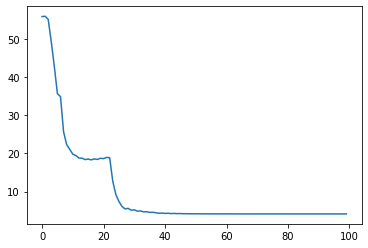

In [10]:
plt.plot(residuals)

In [11]:
A @ x

DeviceArray([0.8940379, 2.620206 , 7.1050715, 4.271683 ], dtype=float32)

In [12]:
b

DeviceArray([1., 2., 3., 4.], dtype=float32)

точность получилась откровенно говоря не очень. Попробуем генерировать системы с заведомо низкоранговым решением, и решать их

In [15]:
def lowrank_approximation(x, rk):
  u, s, v = np.linalg.svd(x)
  s[rk:] = 0
  return u @ np.diag(s) @ v

def system_with_lowrank_solution(n, rk):
  ns = int(jnp.round(jnp.sqrt(n)))

  truex = lowrank_approximation(random.random((ns, ns)), rk)
  
  modes = (ns, ns, ns, ns)
  Acores = ttax.random.tensor(jaxkey, modes, tt_rank=rk)

  Amatrix = ttax.full(Acores).reshape((n, n))

  Amatrix = Amatrix @ Amatrix.T
  
  truex = truex.reshape((n, 1))
  b = Amatrix @ truex
  return Amatrix, b, truex

проверим, что работает генерация низкоранговых систем

In [16]:
n, rk = 4, 2
A, b, truex = system_with_lowrank_solution(n**2, rk)
assert np.linalg.matrix_rank(truex.reshape((n, n))) == rk

n, rk = 16, 2
A, b, truex = system_with_lowrank_solution(n**2, rk)
assert np.linalg.matrix_rank(truex.reshape((n, n))) == rk

n, rk = 32, 8
A, b, truex = system_with_lowrank_solution(n**2, rk)
assert np.linalg.matrix_rank(truex.reshape((n, n))) == rk

Ну все, теперь Риман точно должен работать

In [41]:
n, rk = 2, 3
A, b, truex = system_with_lowrank_solution(n**2, rk)

In [42]:
np.array(A)

array([[ 130.50633 ,  -62.52637 ,   84.75357 , -123.037674],
       [ -62.52637 ,  133.1512  ,  -86.35906 ,  -47.43609 ],
       [  84.75357 ,  -86.35906 ,   78.172424,  -35.49914 ],
       [-123.037674,  -47.43609 ,  -35.49914 ,  228.35161 ]],
      dtype=float32)

In [43]:
x, residuals, rels, energies = solve(A, b.reshape((n**2)), iters=200, tol=1e-2, debug=True)

0 th iteration: 133.47483825683594
10 th iteration: 32.79779815673828
20 th iteration: 10.398239135742188
30 th iteration: 3.8323957920074463
40 th iteration: 1.4413284063339233
50 th iteration: 0.5595380067825317
60 th iteration: 0.4882853031158447
70 th iteration: 0.42625078558921814
80 th iteration: 0.37215927243232727
90 th iteration: 0.32495245337486267
100 th iteration: 0.28387516736984253
110 th iteration: 0.1704103648662567
120 th iteration: 0.14858731627464294
130 th iteration: 0.1893022656440735
140 th iteration: 0.11305707693099976
150 th iteration: 0.09861176460981369
160 th iteration: 0.08601967245340347
170 th iteration: 0.07504349201917648
180 th iteration: 0.09640561789274216
190 th iteration: 0.026147790253162384


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

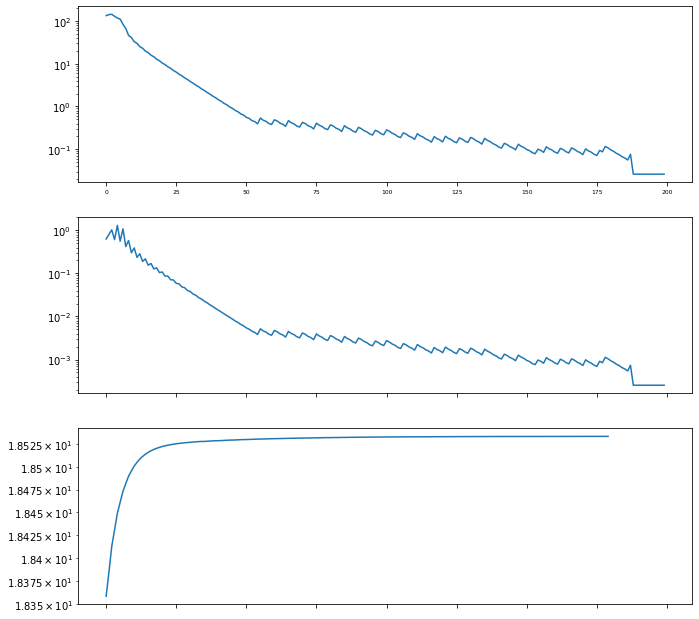

In [44]:
plt.figure(figsize=(11, 11))


ax1 = plt.subplot(311)
plt.semilogy()
plt.plot(residuals)
plt.setp(ax1.get_xticklabels(), fontsize=6)

ax2 = plt.subplot(312, sharex=ax1)
plt.semilogy()

plt.plot(rels)
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(313, sharex=ax2)
plt.semilogy()

plt.plot([abs(x) for x in energies][20:])
# make these tick labels invisible
plt.setp(ax3.get_xticklabels(), visible=False)

Действительно, работает, однако важно следить за длиной шага (снова привет armijo backtracking) (TODO)
Проверим на примере посложнее

In [50]:
n, rk = 32, 2
A, b, truex = system_with_lowrank_solution(n**2, rk)

In [51]:
x, residuals = solve(A, b.reshape((n**2)), iters=200, tol=1e-2, debug=True)

0 th iteration: 1633419.25
10 th iteration: 277352.6875
20 th iteration: 93104.8828125
30 th iteration: 33907.578125
40 th iteration: 12439.8798828125
50 th iteration: 4564.50634765625
60 th iteration: 222.71009826660156
70 th iteration: 221.80418395996094
80 th iteration: 451.85491943359375
90 th iteration: 152.3198699951172
100 th iteration: 1496.3240966796875
110 th iteration: 156.1248016357422
120 th iteration: 148.73719787597656
130 th iteration: 457.2685852050781
140 th iteration: 554.1596069335938
150 th iteration: 367.6994934082031
160 th iteration: 459.0318603515625
170 th iteration: 93.38673400878906
180 th iteration: 672.6717529296875
190 th iteration: 727.6612548828125


ValueError: ignored

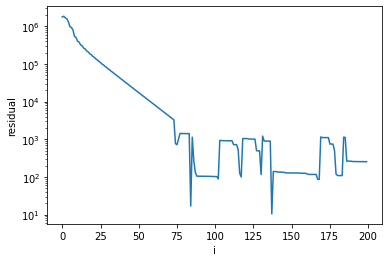

In [24]:
plt.xlabel("i")
plt.ylabel("residual")
plt.semilogy()
plt.plot(residuals)

# Теперь с ttax

в прошлом пункте мы генерили систему, просто развертывая тензор в матрицу и умножая на вектор.
Теперь хочется делать чуть умнее

In [53]:
def ttax_squeeze(A):
  """
    converts a TT representation of A with 2n 3d factors into 
    a n-factor 4d representation convenient for TT-TT multiplication
  """
  return [
          jnp.einsum('abi,icd->abcd', A.tt_cores[i], A.tt_cores[i + 1],
                        precision=jax.lax.Precision.HIGHEST)
          for i in range(0, len(A.tt_cores), 2)
  ]

def ttax_matmul(operator_cores, vector_cores):
  """
  ### этот einsum я подглядел у Ивана
  """
  return ttax.base_class.TT([
      jnp.einsum('abic,eig->aebcg', operator_cores[i], vector_cores.tt_cores[i], precision=jax.lax.Precision.HIGHEST).reshape((
            operator_cores[i].shape[0] * vector_cores.tt_ranks[i], operator_cores[i].shape[1],
            operator_cores[i].shape[3] * vector_cores.tt_ranks[i + 1]), order="F",
      )
      for i in range(len(vector_cores.tt_cores))
  ])

In [54]:
def ttax_make_objective(A, b):
  """
  returns a callable functional of x
  where A is a generic callable operator on x' space
    0.5 * x*A*x - x*b 
  """
  return lambda x: (0.5 * ttax.flat_inner(x, A(x)) - ttax.flat_inner(x, b))

def ttax_norm(x):
  """
   returns a norm of a tensor x 
    <x, x>^0.5 
  """
  return jnp.sqrt(ttax.flat_inner(x, x))

def ttax_make_residual(A, b):
  """
   returns a callable functional of x
   where A is a generic callable operator on x' space
    |A*x - b| 
  """
  return lambda x: ttax_norm(ttax.orthogonalize(A(x) + (-1)*b))

In [55]:
def ttax_retract(TT, v, r):
  """
  returns retraction R(T, v) = T + v
  while rounding result to the closest tensor of rank r
  """
  return ttax.orthogonalize(ttax.round(TT + v, max_tt_rank=r))

def ttax_armijo_backtracking(init, grad, mul, beta, func, x, rk):
    """
    using this one
    """
    alpha = init
    while func(x) < func(ttax_retract(x, -alpha*grad, rk)) + mul*alpha*ttax_norm(grad)**2:
        alpha *= beta
    return alpha

def transpose_operator(operator_cores):
    cores = [jnp.einsum('aijb->ajib', operator_cores[i]) for i in range(len(operator_cores))]
    return cores

In [61]:
def ttax_system_with_lowrank_solution(shape, rk):

  x = ttax.random.tensor(jaxkey, shape, tt_rank=rk)
  
  operatorshape = shape + shape
  for i in range(len(shape)):
    operatorshape[2*i] = shape[i]
    operatorshape[2*i + 1] = shape[i]
  print(operatorshape)
  
  A3dcores = ttax.random.tensor(jaxkey, operatorshape)
  A4dcores = ttax_squeeze(A3dcores)

  A = lambda x: ttax_matmul(A4dcores, x)
  At = lambda x: ttax_matmul(transpose_operator(A4dcores), x)
  ATA = lambda x: At( A( x ) )

  b = ATA( x )
  return ATA, b, x

In [62]:
def ttax_solve(A, b, x0, rk, iters=500, tol=1e-2, debug=False):
  residual = ttax_make_residual(A, b)
  objective = ttax_make_objective(A, b)

  riemann_grad_at = ttax.autodiff.grad(objective)

  x = ttax.orthogonalize(x0)

  residuals = []

  i = 0

  while residual(x) > tol and i < iters:
    riemann_grad = ttax.orthogonalize(riemann_grad_at(x))
    alpha = ttax_armijo_backtracking(1, riemann_grad, 1e-4, 0.8, objective, x, rk)
    
    x = ttax_retract(x, (-alpha)*riemann_grad, rk)

    residuals.append( residual(x) )   
    if i % 10 == 0 and debug:
      print(f"{i} th iteration: {residuals[-1]}")


    i += 1

  return x, residuals

In [68]:
shape = [2, 2, 2]
rk = 3
A, b, truex = ttax_system_with_lowrank_solution(shape, rk)

[2, 2, 2, 2, 2, 2]


In [ ]:
x, residuals = ttax_solve(A, b, x0=b, rk=rk, iters=200, tol=1e-1, debug=True)

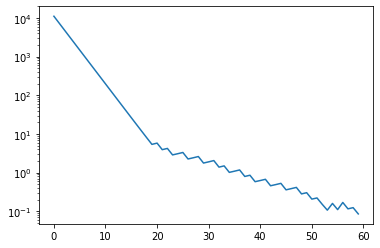

In [66]:
plt.semilogy()
plt.plot(residuals)

Попробуем на рандомном примере. Ожидаем, что ничего не получится

In [30]:
rank = 2

modes_A = [rank] * 8
modes_v = [rank] * 4

A = ttax.random.tensor(jaxkey, modes_A)
A = ttax_squeeze(A)
A_at = lambda x: ttax_matmul(A, x)

t = ttax.random.tensor(jaxkey, modes_v, tt_rank=rank)

In [31]:
x, residuals = ttax_solve(A_at, t, t, rank, iters=10, tol=1e-1, debug=True)

0 th iteration: 132043.15625


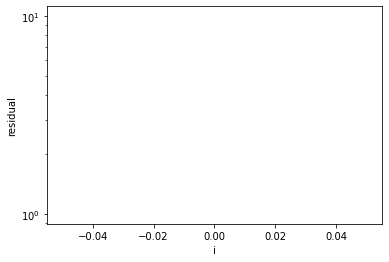

In [32]:
plt.xlabel("i")
plt.ylabel("residual")
plt.semilogy()
plt.show(residuals)

In [34]:
print(residuals)

[DeviceArray(132043.16, dtype=float32), DeviceArray(4714738., dtype=float32), DeviceArray(1.2732396e+09, dtype=float32), DeviceArray(5.848451e+10, dtype=float32), DeviceArray(1.4089597e+13, dtype=float32), DeviceArray(6.935541e+14, dtype=float32), DeviceArray(1.5795935e+17, dtype=float32), DeviceArray(8.089952e+18, dtype=float32), DeviceArray(inf, dtype=float32), DeviceArray(nan, dtype=float32)]


Не работает, как и ожидалось. Осталось написать создание системы с низкоранговым решением , на нем должно заработать

In [217]:
def generic_retract(T, v, rk):
  """
  returns retraction R(T, v) = T + v
  """
  return ttax.round(ttax.orthogonalize(T + v), max_tt_rank=rk)

def generic_armijo_backtracking(init, grad, mul, beta, func, x, rk):
    """
    using this one
    """
    alpha = init
    i = 0
    iters = 50
    while func(x) < func(generic_retract(x, -alpha*grad, rk)) + mul*alpha*ttax_norm(grad)**2:
        alpha *= beta
        if i > iters:
          break
        i += 1
    return alpha

In [218]:
def generic_gd(objective, initial, rk, residual=None, iters=200, tol=1e-2, debug=False):
  riemann_grad_at = ttax.autodiff.grad(objective)
  
  if residual is None:
    residual = lambda x: x
    tol = jnp.inf

  residuals = []
  
  x = initial
  i = 0

  while i < iters:
    riemann_grad = ttax.orthogonalize(riemann_grad_at(ttax.orthogonalize(x)))
    alpha = generic_armijo_backtracking(1, riemann_grad, 1e-4, 0.8, objective, x, rk)
    
    x = generic_retract(x, (-alpha)*riemann_grad, rk)

    if residual is not None:
      r = residual(ttax.orthogonalize(x))
      residuals.append( r )   
      if r < tol:
        break

    if i % 10 == 0 and debug:
      print(f"{i} th iteration, residual {residuals[-1]}")

    i += 1

  return x, residuals

In [219]:
y = lambda A, rk: (lambda x: ttax.flat_inner(A + (-1)*x, A + (-1)*x)**2)

In [220]:
n, rk = 100, 5

In [221]:
A = ttax.random.tensor(jaxkey, shape=(n, n), tt_rank=rk)
np.array(ttax.full(A))[0:3, 0:3]

array([[ 1.6139864 , -0.31247276,  0.7863133 ],
       [-0.27515656, -1.1745789 , -0.09724277],
       [ 5.061904  ,  0.23673698,  1.6336261 ]], dtype=float32)

In [222]:
yA = y(A, rk)

In [223]:
init = ttax.random.tensor(jax.random.PRNGKey(41), shape=(n, n), tt_rank=rk)

In [224]:
x, res = generic_gd(yA, init, rk, debug=True, residual=yA, tol=1e-3)

0 th iteration, residual 280707923968.0
10 th iteration, residual nan
20 th iteration, residual nan
30 th iteration, residual nan
40 th iteration, residual nan
50 th iteration, residual nan
60 th iteration, residual nan
70 th iteration, residual nan
80 th iteration, residual nan


KeyboardInterrupt: ignored

In [195]:
np.array(ttax.full(x))[0:3, 0:3]

array([[ 1.725393  , -1.7029924 ,  0.867786  ],
       [-3.5478938 ,  1.2832911 , -0.77704906],
       [-1.504541  , -1.377178  , -1.8509235 ]], dtype=float32)

In [196]:
res

[DeviceArray(427213.34, dtype=float32),
 DeviceArray(127397.65, dtype=float32),
 DeviceArray(89643.7, dtype=float32),
 DeviceArray(52895.78, dtype=float32),
 DeviceArray(21947.332, dtype=float32),
 DeviceArray(10177.889, dtype=float32),
 DeviceArray(7929.2397, dtype=float32),
 DeviceArray(2684.2732, dtype=float32),
 DeviceArray(503.11038, dtype=float32),
 DeviceArray(304.9241, dtype=float32),
 DeviceArray(258.7402, dtype=float32),
 DeviceArray(111.906334, dtype=float32),
 DeviceArray(60.108948, dtype=float32),
 DeviceArray(14.844092, dtype=float32),
 DeviceArray(2.7070694, dtype=float32),
 DeviceArray(0.7483825, dtype=float32),
 DeviceArray(0.26544347, dtype=float32),
 DeviceArray(0.04692244, dtype=float32),
 DeviceArray(1.4428404e-05, dtype=float32)]